<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/Combination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
Average Test RMS: 0.28924661522891343
Epoch 65001: 0.28880290541791165
Epoch 65002: 0.2887999047381804
Epoch 65003: 0.2894781703763071
Epoch 65004: 0.28895159847154567
Epoch 65005: 0.28894839304507214
Epoch 65006: 0.2887043588603918
Epoch 65007: 0.288382252063976
Epoch 65008: 0.2902790162175816
Epoch 65009: 0.28988423197504354
Epoch 65010: 0.2890938708972145
Epoch 65011: 0.2890487599718685
Epoch 65012: 0.289048046134824
Epoch 65013: 0.2899605246255151
Epoch 65014: 0.2887521913288307
Epoch 65015: 0.28887534093975614
Epoch 65016: 0.2889990409728089
Epoch 65017: 0.28893465056617873
Epoch 65018: 0.2884629634874059
Epoch 65019: 0.28909214209203643
Epoch 65020: 0.2891330279446352
Epoch 65021: 0.2898375829826609
Epoch 65022: 0.2890024362244131
Epoch 65023: 0.28903483189960755
Epoch 65024: 0.28946187107737154
Epoch 65025: 0.2896093233610076
Epoch 65026: 0.28955051614792005
Epoch 65027: 0.2895487108910593
Epoch 65028: 0.28884862620483437
Epoch 

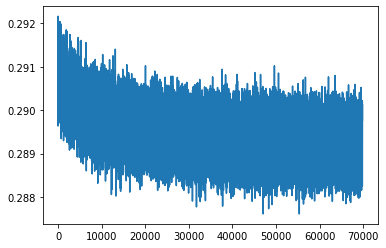

In [6]:
from newsolver import predict_community_fullnp
import numpy as np
import pandas as pd
import random as rd
from numba import njit
from numba.typed import List
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt

data = pd.read_excel('RealData.xlsx', index_col=0)
specs = data.columns.tolist()
trimmed_specs = []

for i in range(len(specs)):
    if data.iloc[:,i].astype(bool).sum() >= 85:
        trimmed_specs.append(specs[i])
dim1 = len(trimmed_specs)

typed_trimmed_specs = List()
[typed_trimmed_specs.append(x) for x in trimmed_specs]

@njit()
def get_LT(full_ar):
    ar = []
    for i in range(len(full_ar)):
        for j in range(i):
            ar.append(full_ar[i][j])
    return ar

@njit()
def generate_matrix(comm, tolerance):
    dim = len(comm)
    ar = np.zeros((dim,dim))

    for i in range(dim):
        for j in range(i+1):
            if i == j:
                ar[i][j] = 0
            else:
                r = rd.random()
                # m = mult[i*dim1+j]
                ar[i][j] = r
                ar[j][i] = (1-r)

    return ar

def datagen():
    lm = generate_matrix(typed_trimmed_specs, 0)
    cm = predict_community_fullnp(lm, trimmed_specs, verb=False)
    return (cm, get_LT(lm))

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
	print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(462, 462*10)
        self.fc2 = nn.Linear(462*10, 231*461)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = MyNet().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, patience=12, threshold=1e-3, verbose=True)

mytest_x = []
mytest_y = []

for i in range(25):
      x, y = datagen()
      mytest_x.append(torch.from_numpy(x).float().to(device))
      mytest_y.append(torch.FloatTensor(y).to(device))

def test_net(test_x, test_y):
    test_loss = 0
    for i in range(len(test_x)):
      input, true_y = test_x[0], test_y[1]

      output = net(input).to(device)
      loss = criterion(output, true_y).to(device)
      test_loss += sqrt((loss.item())/(231*461))

    print(f'Average Test RMS: {test_loss/len(test_x)}')

loss_v = []

for i in range(70000):
    if (i%1000==0) and (i!=0):
      test_net(mytest_x, mytest_y)
      continue

    optimizer.zero_grad()
    x, y = datagen()
    input = torch.from_numpy(x).float().to(device)
    true_y = torch.FloatTensor(y).to(device)

    output = net(input).to(device)

    loss = criterion(output, true_y).to(device)
    s = sqrt((loss.item())/(231*461))
    print(f'Epoch {i}: {s}')
    loss_v.append(s)
    loss.backward()

    optimizer.step()
    # scheduler.step(s)

    


PATH = 'model.pth'
torch.save(net.state_dict(), PATH)

plt.plot(loss_v[100:])
plt.savefig('Loss.png')
plt.show()
